# Nanopore DRS oversplitting detection

We can attempt to detect where the MinKNOW software has oversplit reads by looking for reads which map adjacently that were also sequenced consequectively through the same pore

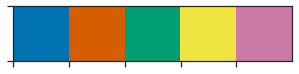

In [2]:
import sys
import re
import os
from glob import glob
from collections import Counter, namedtuple, defaultdict
from operator import add
from functools import reduce
import itertools as it
from operator import attrgetter
import random

import numpy as np
import pandas as pd
from scipy import stats, signal
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import pysam

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [25]:
def get_read_mapping_locs(bam_fn):
    mapping = []
    with pysam.AlignmentFile(bam_fn) as bam:
        for aln in bam.fetch():
            mapping.append([
                aln.query_name,
                aln.reference_name,
                aln.reference_start,
                aln.reference_end,
                ['+', '-'][aln.is_reverse],
            ])
    return pd.DataFrame(mapping, columns=['read_id', 'chrom', 'genomic_start', 'genomic_end', 'strand'])


def get_dist_to_prev(read):
    if not read.strand_same_as_prev or not read.chrom_same_as_prev:
        return np.nan
    if read.strand == '+':
        return read.genomic_start_prev_read - read.genomic_end
    elif read.strand == '-':
        return read.genomic_start - read.genomic_end_prev_read


def read_sequencing_summary(ss_fn, bam_fn):
    ss = []
    for fn in ss_fn:
        #print(fn)
        df = pd.read_csv(fn, sep='\t')
        ss.append(df)
    ss = pd.concat(ss, axis=0)
    ss = ss.sort_values(['channel', 'start_time'])
    ss['end_time'] = ss['start_time'] + ss['duration']
    ss['prev_read_id'] = ss.groupby('channel').read_id.shift(1)
    ss['prev_end_time'] = ss.groupby('channel').end_time.shift(1)
    ss['missing_signal_time'] = ss.start_time - ss.prev_end_time
    mapped_loc = get_read_mapping_locs(bam_fn)
    ss = ss.merge(mapped_loc, on='read_id', how='left')
    ss = ss.merge(
        mapped_loc,
        left_on='prev_read_id',
        right_on='read_id',
        suffixes=('', '_prev_read'),
        how='left'
    ).drop('read_id_prev_read', axis=1)
    ss['chrom_same_as_prev'] = ss.chrom == ss.chrom_prev_read
    ss['strand_same_as_prev'] = ss.strand == ss.strand_prev_read
    ss['genomic_dist_to_prev'] = ss.apply(get_dist_to_prev, axis=1)
    return ss

In [30]:
datasets = ['/public/home/mowp/test/nanopore_cdna/aligned_data/fhh.mm2.sorted.bam', ]

sequencing_summaries= [['/public/home/mowp/test/nanopore_cdna/basecalled_data/sequencing_summary.txt'], ]

In [31]:
oversplitting_res = {}
oversplitting_stats = []
for ss_fn, bam_fn in zip(sequencing_summaries, datasets):
    sample_name = os.path.splitext(os.path.split(bam_fn)[1])[0]
    ss = read_sequencing_summary(ss_fn, bam_fn)
    ss_mapped_only = ss[~ss.chrom.isnull()]
    is_oversplit = (
        ss_mapped_only.chrom_same_as_prev & 
        ss_mapped_only.strand_same_as_prev & 
        (ss_mapped_only.genomic_dist_to_prev < 1000).fillna(False) &
        (ss_mapped_only.genomic_dist_to_prev > -10).fillna(False)
    )
    ss_mapped_only['is_oversplit'] = is_oversplit
    oversplitting_stats.append(
        (sample_name,  is_oversplit.sum(), is_oversplit.sum() / len(is_oversplit) * 100)
    )
    oversplitting_res[sample_name] = ss_mapped_only

oversplitting_stats = pd.DataFrame(oversplitting_stats, columns=['sample_name', 'total_oversplit', 'percent_oversplit'])

/public/home/mowp/test/nanopore_cdna/basecalled_data/sequencing_summary.txt


/public/home/mowp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [17]:
oversplitting_stats

,sample_name,total_oversplit,percent_oversplit
0,fhh.mm2.sorted,46,0.000673
